Transaction Table *

* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:

* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

Identity Table *

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

* Categorical Features:
* DeviceType
* DeviceInfo
* id_12 - id_38



In [142]:
import pandas as pd
import numpy as np
import gc
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 12, 10

In [2]:
train_identity = pd.read_csv('data/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('data/ieee-fraud-detection/train_transaction.csv')

In [3]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
train = train.drop(columns=[x for x in train.columns if x.startswith("V")])
train.shape
train.to_pickle("train.pkl")

In [4]:
del train_identity, train_transaction
gc.collect()

40

In [5]:
test_identity = pd.read_csv('data/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('data/ieee-fraud-detection/test_transaction.csv')

In [6]:
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
test = test.drop(columns=[x for x in test.columns if x.startswith("V")])
test.shape
test.to_pickle("test.pkl")

In [7]:
del test_identity, test_transaction
gc.collect()

40

In [8]:
test["isFraud"] = "test"

In [9]:
train.shape, test.shape

((590540, 95), (506691, 95))

In [10]:
for col in list(train.columns):
    if col not in list(test.columns):
        print(" only in train: ", col, end = "  ")
for col in list(test.columns):
    if col not in list(train.columns):
        print(" only in test: ", col, end = "  ") 

 only in train:  id_01   only in train:  id_02   only in train:  id_03   only in train:  id_04   only in train:  id_05   only in train:  id_06   only in train:  id_07   only in train:  id_08   only in train:  id_09   only in train:  id_10   only in train:  id_11   only in train:  id_12   only in train:  id_13   only in train:  id_14   only in train:  id_15   only in train:  id_16   only in train:  id_17   only in train:  id_18   only in train:  id_19   only in train:  id_20   only in train:  id_21   only in train:  id_22   only in train:  id_23   only in train:  id_24   only in train:  id_25   only in train:  id_26   only in train:  id_27   only in train:  id_28   only in train:  id_29   only in train:  id_30   only in train:  id_31   only in train:  id_32   only in train:  id_33   only in train:  id_34   only in train:  id_35   only in train:  id_36   only in train:  id_37   only in train:  id_38   only in test:  id-01   only in test:  id-02   only in test:  id-03   only in test:  id-

In [11]:
test.columns=test.columns.str.replace('-','_')

In [12]:
for col in list(train.columns):
    if col not in list(test.columns):
        print(" only in train: ", col, end = "  ")
for col in list(test.columns):
    if col not in list(train.columns):
        print(" only in test: ", col, end = "  ") 

In [13]:
train.shape, test.shape

((590540, 95), (506691, 95))

In [14]:
list(set(train.columns) - set(test.columns))

[]

In [15]:
frauds = train.shape[0]
yes = train['isFraud'].sum()
no = frauds - yes
print('{} frauds'.format(frauds))
print('{} yes \n{} no'.format(yes,no))

590540 frauds
20663 yes 
569877 no


# remove columns over 80% missing

In [16]:
def remove_columns(perc_limit):
    missing_perc = (train.isna().sum() / train.isna().count()).sort_values(ascending=False)
    print("missing perc:", dict(missing_perc))
    perc_too_high_cols = missing_perc[missing_perc > perc_limit].index
    print("Columns over the limit:",perc_too_high_cols)
    print(train.shape, test.shape)
    train.drop(columns=perc_too_high_cols, inplace=True)
    test.drop(columns=perc_too_high_cols, inplace=True)
    print(train.shape, test.shape)
    
remove_columns(0.80)

missing perc: {'id_24': 0.9919615944728554, 'id_25': 0.9913096487960172, 'id_07': 0.9912707013919464, 'id_08': 0.9912707013919464, 'id_21': 0.9912639279303688, 'id_26': 0.9912571544687913, 'id_22': 0.9912469942764249, 'id_23': 0.9912469942764249, 'id_27': 0.9912469942764249, 'dist2': 0.9362837403054831, 'D7': 0.9340992989467267, 'id_18': 0.9236072069631185, 'D13': 0.8950926270870728, 'D14': 0.8946946862193924, 'D12': 0.8904104717715988, 'id_03': 0.8876892335828225, 'id_04': 0.8876892335828225, 'D6': 0.8760676668811597, 'id_33': 0.8758949436109323, 'D8': 0.8731229044603245, 'id_10': 0.8731229044603245, 'id_09': 0.8731229044603245, 'D9': 0.8731229044603245, 'id_30': 0.868654113184543, 'id_32': 0.8686185525112609, 'id_34': 0.8682477054898906, 'id_14': 0.8644562603718631, 'DeviceInfo': 0.7990551021099332, 'id_13': 0.7844007179869272, 'id_16': 0.7809801198902699, 'id_05': 0.7682375452975243, 'id_06': 0.7682375452975243, 'R_emaildomain': 0.7675161716395164, 'id_20': 0.7641802418125783, 'id_1

In [17]:
# save train and test
train.to_pickle("train1.pkl")
# test.to_pickle("test1.pkl")
# train = pd.read_pickle("train1.pkl")
list(train.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D11',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_01',
 'id_02',
 'id_05',
 'id_06',
 'id_11',
 'id_12',
 'id_13',
 'id_15',
 'id_16',
 'id_17',
 'id_19',
 'id_20',
 'id_28',
 'id_29',
 'id_31',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

## Remove too many NaN on rows

In [18]:
def drop_more_than_N_Nan(N): # of the 68 columns, only 12 allowed to be NaN
    print(train.shape)
    train.dropna(thresh=train.shape[1]-N, axis=0, inplace=True)
    print(train.shape)
    
drop_more_than_N_Nan(12)
train.shape, list(train.columns)

(590540, 68)
(11074, 68)


((11074, 68),
 ['TransactionID',
  'isFraud',
  'TransactionDT',
  'TransactionAmt',
  'ProductCD',
  'card1',
  'card2',
  'card3',
  'card4',
  'card5',
  'card6',
  'addr1',
  'addr2',
  'dist1',
  'P_emaildomain',
  'R_emaildomain',
  'C1',
  'C2',
  'C3',
  'C4',
  'C5',
  'C6',
  'C7',
  'C8',
  'C9',
  'C10',
  'C11',
  'C12',
  'C13',
  'C14',
  'D1',
  'D2',
  'D3',
  'D4',
  'D5',
  'D10',
  'D11',
  'D15',
  'M1',
  'M2',
  'M3',
  'M4',
  'M5',
  'M6',
  'M7',
  'M8',
  'M9',
  'id_01',
  'id_02',
  'id_05',
  'id_06',
  'id_11',
  'id_12',
  'id_13',
  'id_15',
  'id_16',
  'id_17',
  'id_19',
  'id_20',
  'id_28',
  'id_29',
  'id_31',
  'id_35',
  'id_36',
  'id_37',
  'id_38',
  'DeviceType',
  'DeviceInfo'])

# Prepare Train 

In [19]:
train.set_index("TransactionID", inplace=True)
train.shape, train.columns

((11074, 67),
 Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
        'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
        'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
        'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3',
        'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6',
        'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_12',
        'id_13', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29',
        'id_31', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
        'DeviceInfo'],
       dtype='object'))

## check categories

In [20]:
def check_categories():
    for col, values in train.loc[:, train.dtypes == object].iteritems():
        num_uniques = values.nunique()
        if num_uniques > 5:
            print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
            print (values.unique()[:20], "....")
            print ("")
            print (values.value_counts()[:10])
            print ('\n')
            
check_categories()

P_emaildomain: 46
['gmail.com' 'anonymous.com' 'hotmail.com' 'att.net' 'outlook.com'
 'servicios-ta.com' 'yahoo.com.mx' 'icloud.com' 'live.com.mx' 'msn.com'
 'aol.com' 'yahoo.com' 'verizon.net' 'web.de' 'yahoo.fr' 'hotmail.fr'
 'comcast.net' 'outlook.es' 'earthlink.net' 'prodigy.net.mx'] ....

gmail.com        4102
hotmail.com      3784
anonymous.com    1391
outlook.com       308
yahoo.com         294
yahoo.com.mx      214
aol.com           131
live.com.mx       127
live.com           76
outlook.es         64
Name: P_emaildomain, dtype: int64


R_emaildomain: 49
['gmail.com' 'anonymous.com' 'hotmail.com' 'att.net' 'outlook.com'
 'servicios-ta.com' 'yahoo.com.mx' nan 'icloud.com' 'live.com.mx'
 'msn.com' 'aol.com' 'yahoo.com' 'verizon.net' 'bellsouth.net' 'web.de'
 'yahoo.fr' 'hotmail.fr' 'comcast.net' 'outlook.es'] ....

gmail.com        4133
hotmail.com      3780
anonymous.com    1387
outlook.com       308
yahoo.com         279
yahoo.com.mx      214
live.com.mx       135
aol.com      

## add new column from emails which are the same

In [21]:
train['is_email_same'] = train.apply(lambda x: x['P_emaildomain']== x['R_emaildomain'] and x['R_emaildomain'] != np.nan, axis=1)

In [22]:
train['is_email_same'].value_counts()

True     10531
False      543
Name: is_email_same, dtype: int64

In [23]:
train[train['P_emaildomain'] == train['R_emaildomain']].filter(["P_emaildomain","R_emaildomain"])

,P_emaildomain,R_emaildomain
TransactionID,,
2987010,gmail.com,gmail.com
2987130,gmail.com,gmail.com
2987252,anonymous.com,anonymous.com
2987258,anonymous.com,anonymous.com
2987328,gmail.com,gmail.com
...,...,...
3577365,gmail.com,gmail.com
3577469,hotmail.com,hotmail.com
3577486,gmail.com,gmail.com


In [24]:
train.groupby(["P_emaildomain", "isFraud"]).size().unstack(level=1)

isFraud,0,1
P_emaildomain,,
aim.com,1.0,NaN
anonymous.com,1367.0,24.0
aol.com,131.0,NaN
att.net,11.0,NaN
bellsouth.net,11.0,NaN
cableone.net,1.0,NaN
charter.net,10.0,NaN
comcast.net,49.0,NaN
cox.net,9.0,NaN


In [25]:
train.groupby(["P_emaildomain"]).apply(lambda x: x['isFraud'].sum()/x['isFraud'].count())

P_emaildomain
aim.com             0.000000
anonymous.com       0.017254
aol.com             0.000000
att.net             0.000000
bellsouth.net       0.000000
cableone.net        0.000000
charter.net         0.000000
comcast.net         0.000000
cox.net             0.000000
earthlink.net       0.000000
embarqmail.com      0.000000
gmail               0.000000
gmail.com           0.087518
gmx.de              0.000000
hotmail.co.uk       0.000000
hotmail.com         0.045190
hotmail.de          0.000000
hotmail.es          0.000000
hotmail.fr          0.000000
icloud.com          0.222222
juno.com            0.000000
live.com            0.026316
live.com.mx         0.007874
live.fr             0.000000
mac.com             0.285714
mail.com            0.250000
me.com              0.000000
msn.com             0.000000
netzero.com         0.000000
optonline.net       0.000000
outlook.com         0.061688
outlook.es          0.125000
prodigy.net.mx      0.000000
q.com               0.000000


In [26]:
def get_perc(x):
    return x.sum()/x.count()

In [27]:
train.groupby(["P_emaildomain"]).agg(P_emaildomain_PercFraud=("isFraud", get_perc)).reset_index().sort_values("P_emaildomain_PercFraud", ascending=False)

,P_emaildomain,P_emaildomain_PercFraud
24,mac.com,0.285714
25,mail.com,0.250000
19,icloud.com,0.222222
31,outlook.es,0.125000
12,gmail.com,0.087518
30,outlook.com,0.061688
15,hotmail.com,0.045190
21,live.com,0.026316
1,anonymous.com,0.017254
40,yahoo.com,0.010204


In [28]:
email_repl_dict = {re.compile('.*gmail.*'): 'gmail',
             re.compile('.*hotmail.*'): 'hotmail',
             re.compile('.*yahoo.*'): 'yahoo',
             re.compile('.*aol.*'): 'aol',
             re.compile('.*anonymous.*'): 'anonymous',
             re.compile('.*outlook.*'): 'outlook',
             re.compile('.*protonmail.*'): 'protonmail'}

In [29]:
d = defaultdict(lambda: 'other')
d.update(dict(zip(email_repl_dict.values(), email_repl_dict.values())))

In [30]:
train['P_emaildomain'] = train['P_emaildomain'].replace(email_repl_dict, regex=True, inplace=False).map(d)
train['P_emaildomain'].value_counts().head(15)

gmail        4125
hotmail      3883
anonymous    1391
other         592
yahoo         580
outlook       372
aol           131
Name: P_emaildomain, dtype: int64

In [31]:
train['R_emaildomain'] = train['R_emaildomain'].replace(email_repl_dict, regex=True, inplace=False).map(d)
train['R_emaildomain'].value_counts().head(15)

gmail        4156
hotmail      3879
anonymous    1387
other         596
yahoo         567
outlook       372
aol           117
Name: R_emaildomain, dtype: int64

In [32]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(train.groupby(["id_31"]).agg({"isFraud":[get_perc, "count"]}, as_index=False).reset_index()[['id_31','isFraud']].sort_values(('isFraud','count'), ascending=False))

                             id_31   isFraud      
                                    get_perc count
35                     chrome 63.0  0.039526  1771
36         chrome 63.0 for android  0.073988   865
39         chrome 64.0 for android  0.052925   718
38                     chrome 64.0  0.037518   693
42         chrome 65.0 for android  0.091052   637
41                     chrome 65.0  0.050847   590
32                     chrome 62.0  0.102740   584
49                  chrome generic  0.065292   582
45         chrome 66.0 for android  0.036395   577
70             ie 11.0 for desktop  0.005556   540
44                     chrome 66.0  0.040000   450
50      chrome generic for android  0.037879   264
63                    firefox 57.0  0.035714   252
33         chrome 62.0 for android  0.072727   220
55                       edge 16.0  0.004950   202
92             samsung browser 6.4  0.026490   151
91             samsung browser 6.2  0.093333   150
65                    firefox 5

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(train.groupby(["DeviceInfo"]).agg({"isFraud":[get_perc, "count"]}, as_index=False).reset_index()[['DeviceInfo','isFraud']].sort_values(('isFraud','count'), ascending=False))

                                      DeviceInfo   isFraud      
                                                  get_perc count
648                                      Windows  0.044958  4849
634                                  Trident/7.0  0.005952   504
692                                   iOS Device  0.014563   206
290                                        MacOS  0.010695   187
567                        SM-J700M Build/MMB29K  0.051095   137
487                        SM-G531H Build/LMY48B  0.023810   126
494                        SM-G610M Build/MMB29K  0.000000    96
698                                      rv:11.0  0.000000    83
710                                      rv:57.0  0.070423    71
488                        SM-G532M Build/MMB29T  0.000000    71
533                        SM-G935F Build/NRD90M  0.015625    64
562                       SM-J510MN Build/MMB29M  0.171875    64
32                   ALE-L23 Build/HuaweiALE-L23  0.016393    61
312               Moto G 

In [34]:
DeviceInfo_repl_dict = {re.compile('.*rv.*'): 'rv',
             re.compile('.*indows.*'): 'windows',
             re.compile('.*iOS.*'): 'ios',
             re.compile('.*Build.*'): 'build',
             re.compile('.*rident.*'): 'trident',
             re.compile('.*Moto.*'): 'moto'
                  }

In [35]:
d = defaultdict(lambda: 'other')
d.update(dict(zip(DeviceInfo_repl_dict.values(), DeviceInfo_repl_dict.values())))
train['DeviceInfo'] = train['DeviceInfo'].replace(DeviceInfo_repl_dict, regex=True, inplace=False).map(d)
train['DeviceInfo'].value_counts().head(15)

windows    4854
build      4516
other       644
trident     504
rv          309
ios         206
moto         41
Name: DeviceInfo, dtype: int64

In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(train.groupby(["id_31"]).agg({"isFraud":[get_perc, "count"]}, as_index=False).reset_index()[['id_31','isFraud']].sort_values(('isFraud','get_perc'), ascending=False))

                             id_31   isFraud      
                                    get_perc count
20                     chrome 56.0  1.000000     4
69                              ie  0.800000     5
15         chrome 52.0 for android  0.577465    71
9          chrome 43.0 for android  0.500000     2
13         chrome 50.0 for android  0.354839    31
56                       edge 17.0  0.333333     3
81                   opera generic  0.250000     4
47                     chrome 67.0  0.222222     9
5                 Samsung/SM-G532M  0.187500    32
25         chrome 58.0 for android  0.142857    35
88             samsung browser 4.0  0.142857     7
77                           opera  0.125000     8
21         chrome 56.0 for android  0.125000    32
32                     chrome 62.0  0.102740   584
91             samsung browser 6.2  0.093333   150
42         chrome 65.0 for android  0.091052   637
59                    firefox 48.0  0.076923    13
82                           ot

In [37]:
id_31_repl_dict = {re.compile('.*icedragon.*'): 'icedragon',
             re.compile('.*irefox.*'): 'firefox',
             re.compile('.*android.*'): 'android',
             re.compile('.*chrome.*'): 'chrome',
             re.compile('.*safari.*'): 'safari',
             re.compile('.*ie.*'): 'ie',
             re.compile('.*edge.*'): 'ie',
             re.compile('.*samsung browser.*'): 'samsung',
             re.compile('.*opera*'): 'opera'
                  }

In [38]:
d = defaultdict(lambda: 'other')
d.update(dict(zip(id_31_repl_dict.values(), id_31_repl_dict.values())))
train['id_31'] = train['id_31'].replace(id_31_repl_dict, regex=True, inplace=False).map(d)
train['id_31'].value_counts().head(15)

chrome     4801
android    3834
ie          901
firefox     615
samsung     391
safari      368
other       156
opera         8
Name: id_31, dtype: int64

## again remove empty columns

In [39]:
remove_columns(0.80)

missing perc: {'M5': 1.0, 'M3': 1.0, 'M2': 1.0, 'M1': 1.0, 'D11': 1.0, 'M6': 1.0, 'M7': 1.0, 'dist1': 1.0, 'M8': 1.0, 'M9': 1.0, 'addr1': 0.8166877370417194, 'addr2': 0.8166877370417194, 'M4': 0.10502076936969477, 'D3': 0.04117753296008669, 'D2': 0.03955210402745169, 'D10': 0.017518511829510565, 'D15': 0.008849557522123894, 'D5': 0.007946541448437781, 'id_16': 0.005598699656853892, 'id_13': 0.0027090482210583348, 'id_20': 0.0002709048221058335, 'card5': 0.00018060321473722233, 'id_06': 0.00018060321473722233, 'id_05': 0.00018060321473722233, 'card2': 9.030160736861116e-05, 'DeviceInfo': 0.0, 'DeviceType': 0.0, 'id_38': 0.0, 'id_37': 0.0, 'id_36': 0.0, 'id_29': 0.0, 'id_35': 0.0, 'id_31': 0.0, 'id_19': 0.0, 'id_01': 0.0, 'id_02': 0.0, 'id_11': 0.0, 'id_12': 0.0, 'id_28': 0.0, 'id_17': 0.0, 'id_15': 0.0, 'isFraud': 0.0, 'TransactionDT': 0.0, 'D4': 0.0, 'TransactionAmt': 0.0, 'ProductCD': 0.0, 'card1': 0.0, 'card3': 0.0, 'card4': 0.0, 'card6': 0.0, 'P_emaildomain': 0.0, 'R_emaildomain': 0

# some corr matrices 

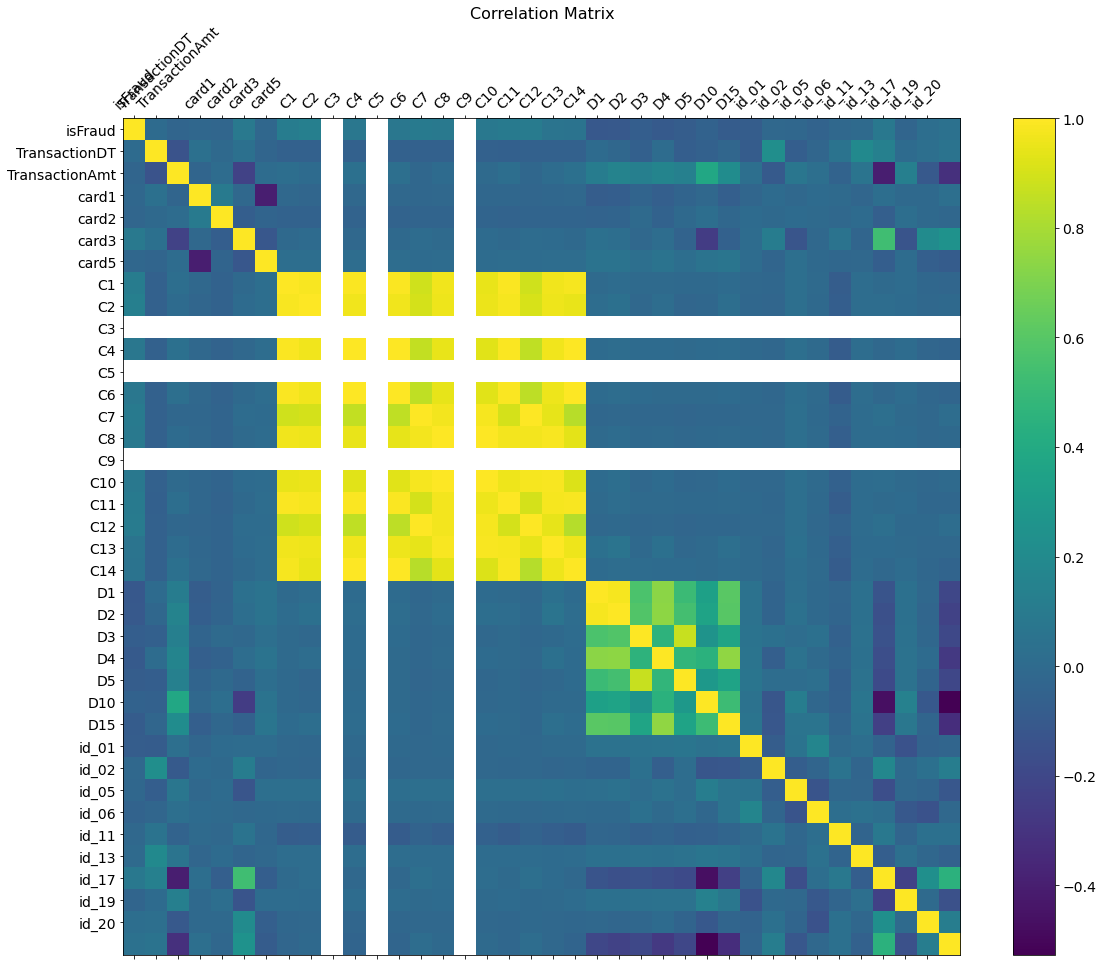

In [40]:
f = plt.figure(figsize=(19, 15))
plt.matshow(train.corr(), fignum=f.number)
plt.xticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

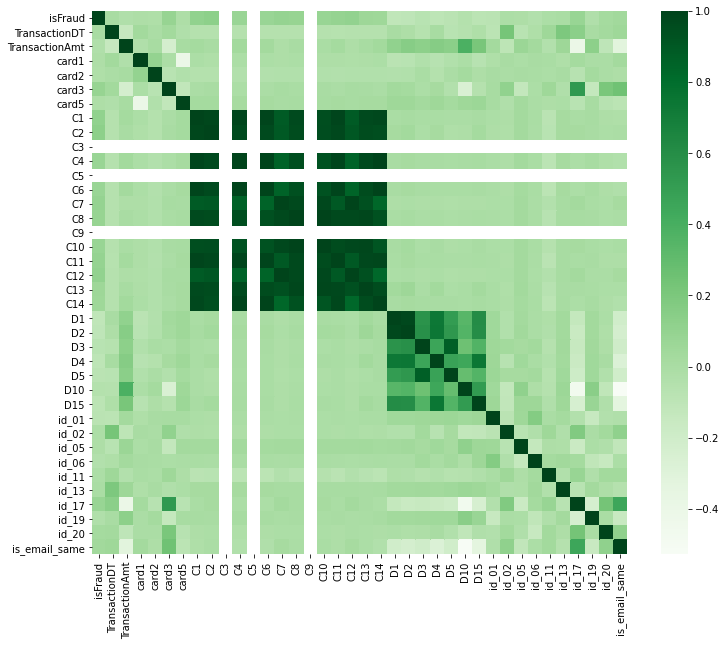

In [41]:
corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=False, cmap="Greens")
plt.show()

as we can see no features are highly correlated if the isFruad, because that would make it too easy :) 

However card3 and is_email_same show promise

In [42]:
print(train.sample(5).T.to_string())

TransactionID    3003421     3264190   3307195   3151316           3082408
isFraud                0           0         0         0                 0
TransactionDT     435638     6735276   7953023   3502731           1963570
TransactionAmt    11.604       6.525   123.257    42.676             100.0
ProductCD              C           C         C         C                 R
card1              15885        3154      3702      9633              9393
card2              545.0       408.0     311.0     296.0             399.0
card3              185.0       185.0     185.0     185.0             150.0
card4               visa  mastercard      visa      visa  american express
card5              138.0       224.0     102.0     138.0             150.0
card6              debit       debit     debit     debit            credit
P_emaildomain    hotmail     hotmail     gmail     gmail         anonymous
R_emaildomain    hotmail     hotmail     gmail     gmail         anonymous
C1                   5.0 

In [43]:
# (train
#     .filter(corrMatrix.columns)
#      .query("isFraud == 1")
#      .drop('isFraud', axis=1)
# )

I don't think we have ordinal values, but I need to encode to use them 

In [109]:
def missing_vals(df):
    x = []
    for col in df.columns:
        vals = train[col].value_counts().shape[0]
        missing = round((train[col].isna().sum()/train[col].shape[0])*100,2)
        x.append([col,vals,missing])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(pd.DataFrame(x, columns=["col","vals","missing"]).set_index("col"))

missing_vals(train)

                 vals  missing
col                           
isFraud             2     0.00
TransactionDT   11070     0.00
TransactionAmt   2895     0.00
ProductCD           3     0.00
card1            1031     0.00
card2             165     0.00
card3              54     0.00
card4               4     0.00
card5              46     0.00
card6               3     0.00
P_emaildomain       7     0.00
R_emaildomain       7     0.00
C1                108     0.00
C2                165     0.00
C3                  1     0.00
C4                 70     0.00
C5                  1     0.00
C6                 69     0.00
C7                 59     0.00
C8                 79     0.00
C9                  1     0.00
C10                84     0.00
C11                98     0.00
C12                91     0.00
C13               105     0.00
C14                48     0.00
D1                600     0.00
D2                820     0.00
D3                753     0.00
D4                711     0.00
D5      

In [45]:
# list(train.columns)
list(train.loc[:,train.dtypes != object])

['isFraud',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D15',
 'id_01',
 'id_02',
 'id_05',
 'id_06',
 'id_11',
 'id_13',
 'id_17',
 'id_19',
 'id_20',
 'is_email_same']

In [46]:
train.to_pickle("train2.pkl")

In [257]:
# train = pd.read_pickle("train2.pkl")

# scale everything

In [259]:
num_cols_mask = (train.dtypes != object) & (train.columns != 'isFraud') & (train.nunique()>2)
not_num_cols_mask = (train.dtypes == object)
num_cols = train.columns[num_cols_mask]
not_num_cols = train.columns[not_num_cols_mask]

In [260]:
list(num_cols)

['TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'C1',
 'C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D15',
 'id_01',
 'id_02',
 'id_05',
 'id_06',
 'id_11',
 'id_13',
 'id_17',
 'id_19',
 'id_20']

In [261]:
list(not_num_cols)

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M4',
 'id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_31',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

In [262]:
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])

In [263]:
train[num_cols]

,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C4,C6,...,D15,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987010,-1.540230,0.204474,1.291922,-0.303596,-2.629217,-1.094509,-0.075739,-0.096522,-0.071358,-0.068478,...,-0.562586,0.402072,-0.124557,-0.141240,0.423461,0.148477,0.342865,-3.759908,0.651197,-2.219086
2987130,-1.539791,0.153940,0.672453,1.124510,-2.629217,0.986556,-0.062512,-0.075946,-0.071358,-0.068478,...,-0.562586,0.082852,-0.226863,-0.141240,0.423461,0.148477,0.342865,-3.759908,0.651197,-2.219086
2987252,-1.539420,-0.073479,-1.521019,0.111016,0.493905,0.285328,-0.075739,-0.117098,-0.071358,-0.068478,...,-0.562586,0.402072,-0.502662,-0.141240,0.423461,0.148477,0.342865,0.420427,-0.529948,-0.844170
2987258,-1.539396,-0.073479,-1.521019,0.111016,0.493905,0.285328,-0.075739,-0.106810,-0.071358,-0.068478,...,-0.562586,0.402072,-0.690258,-0.141240,0.423461,0.148477,0.342865,0.420427,-0.529948,-0.844170
2987328,-1.539140,-0.397660,-1.317789,0.064948,0.493905,0.941316,-0.075739,-0.117098,-0.071358,-0.068478,...,-0.562586,0.402072,0.025816,-0.141240,0.423461,0.148477,0.342865,0.420427,-1.268164,0.523233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577365,1.798646,-0.148177,1.603710,1.032374,0.723546,0.986556,-0.062512,-0.106810,-0.071358,-0.068478,...,-0.134044,0.082852,-0.638569,0.106472,0.423461,0.148477,0.342865,0.420427,0.790638,-0.919302
3577469,1.799105,0.027240,0.854557,0.670412,0.493905,0.941316,-0.075739,-0.014219,-0.071358,-0.068478,...,-0.556464,0.082852,-0.960703,-0.141240,0.423461,0.148477,0.342865,0.420427,0.790638,1.184394
3577486,1.799168,-0.148177,1.172409,0.966563,0.493905,-1.004028,-0.075739,-0.117098,-0.071358,-0.068478,...,0.000640,0.402072,2.511582,-0.141240,0.423461,0.148477,-1.725229,0.420427,0.790638,-0.844170


In [264]:
train[num_cols].describe().round(3).T.sort_values("max", ascending=False)

,count,mean,std,min,25%,50%,75%,max
C7,11074.0,-0.0,1.0,-0.084,-0.060,-0.060,-0.035,28.919
C12,11074.0,0.0,1.0,-0.088,-0.069,-0.069,-0.051,28.904
C8,11074.0,-0.0,1.0,-0.092,-0.076,-0.060,-0.043,28.401
C10,11074.0,0.0,1.0,-0.099,-0.085,-0.070,-0.040,28.320
C13,11074.0,-0.0,1.0,-0.119,-0.103,-0.086,-0.054,27.410
C11,11074.0,0.0,1.0,-0.077,-0.077,-0.061,-0.061,26.068
C1,11074.0,-0.0,1.0,-0.089,-0.076,-0.076,-0.063,25.478
C14,11074.0,0.0,1.0,-0.098,-0.066,-0.066,-0.034,24.845
C4,11074.0,-0.0,1.0,-0.093,-0.071,-0.071,-0.050,24.816
C2,11074.0,0.0,1.0,-0.127,-0.117,-0.097,-0.066,24.708


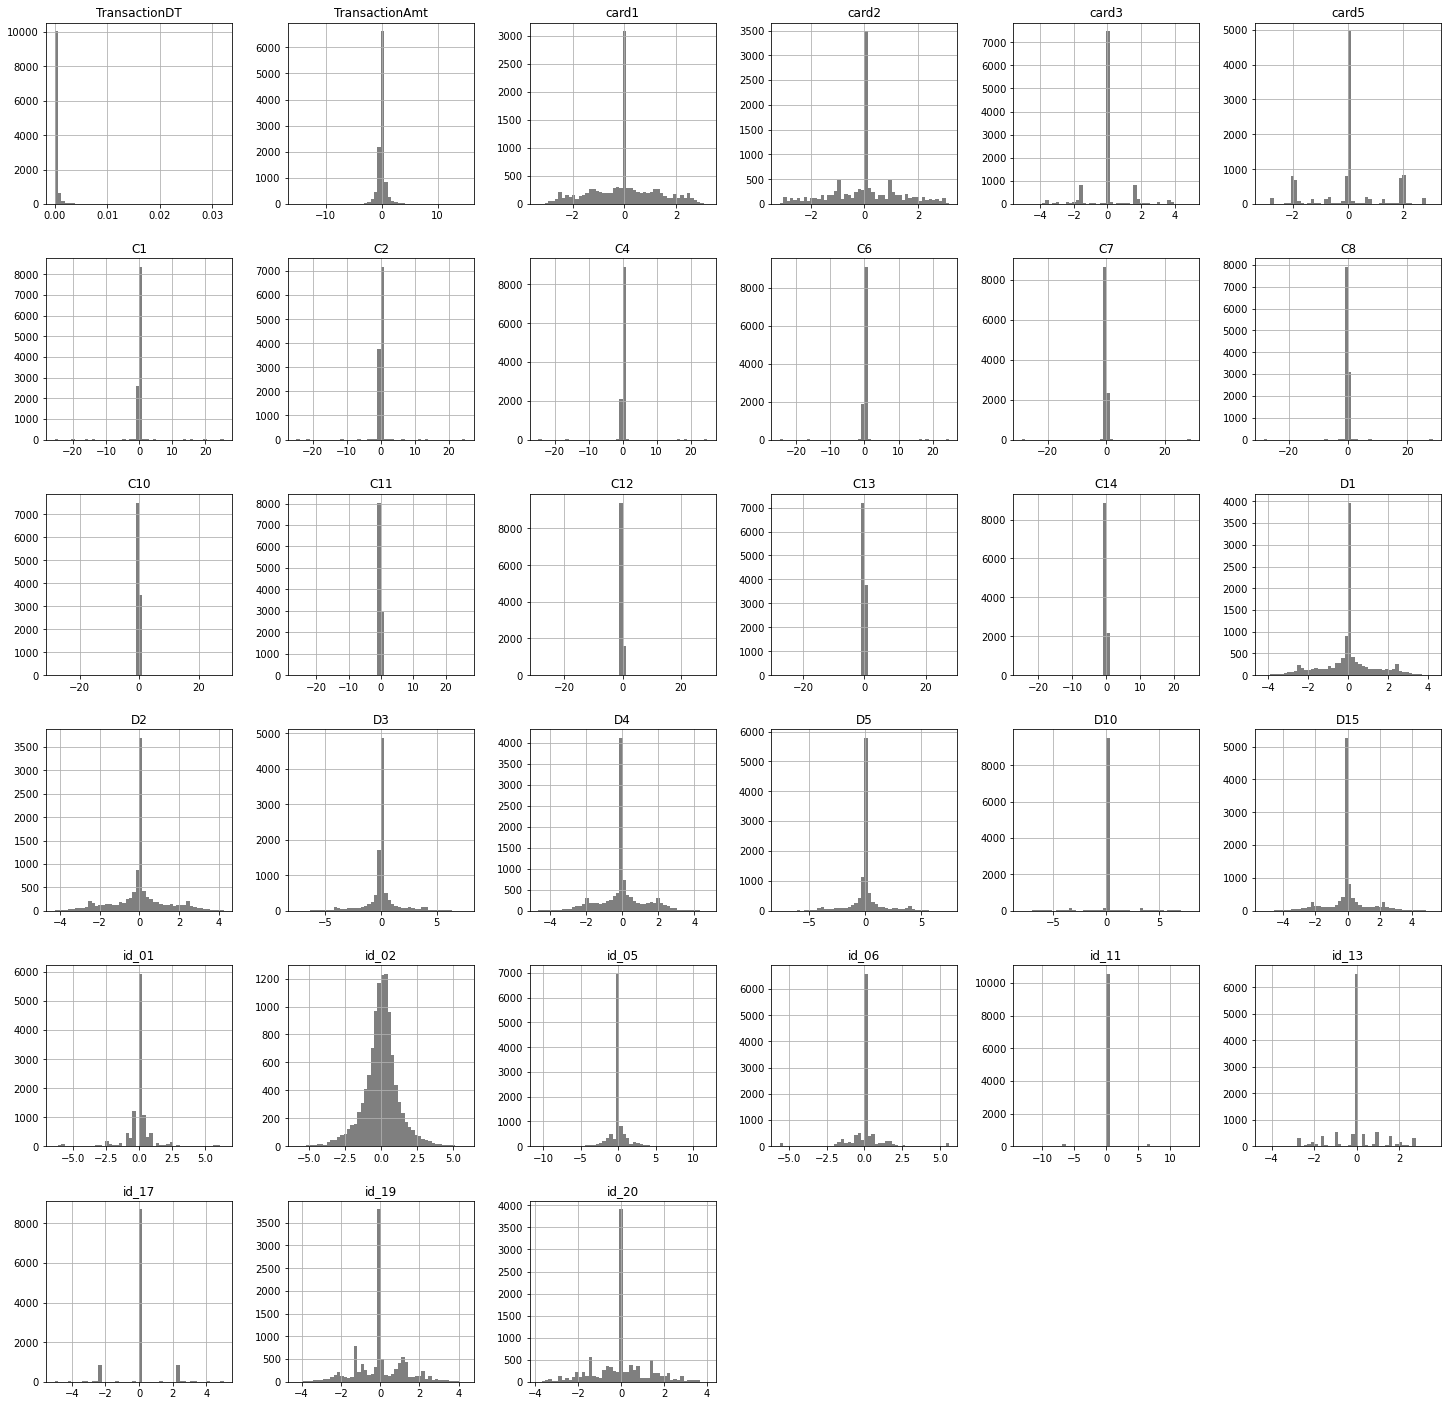

In [265]:
train[num_cols].diff().hist(color="k", alpha=0.5, bins=50, figsize=(25,25));


Remove NaN

# remove outliers and fill missing

In [266]:
missing_vals(train)

                 vals  missing
col                           
isFraud             2     0.00
TransactionDT   11070     0.00
TransactionAmt   2895     0.00
ProductCD           3     0.00
card1            1031     0.00
card2             164     0.01
card3              54     0.00
card4               4     0.00
card5              44     0.02
card6               3     0.00
P_emaildomain       7     0.00
R_emaildomain       7     0.00
C1                108     0.00
C2                165     0.00
C3                  1     0.00
C4                 70     0.00
C5                  1     0.00
C6                 69     0.00
C7                 59     0.00
C8                 79     0.00
C9                  1     0.00
C10                84     0.00
C11                98     0.00
C12                91     0.00
C13               105     0.00
C14                48     0.00
D1                600     0.00
D2                598     3.96
D3                464     4.12
D4                711     0.00
D5      

In [267]:
print(train.shape)
imp_kNN = KNNImputer(missing_values = np.nan)
imp_kNN.fit(train[num_cols])
train[num_cols] = imp_kNN.transform(train[num_cols])
print(train.shape)

(11074, 56)
(11074, 56)


In [268]:
missing_vals(train)

                 vals  missing
col                           
isFraud             2     0.00
TransactionDT   11070     0.00
TransactionAmt   2895     0.00
ProductCD           3     0.00
card1            1031     0.00
card2             165     0.00
card3              54     0.00
card4               4     0.00
card5              46     0.00
card6               3     0.00
P_emaildomain       7     0.00
R_emaildomain       7     0.00
C1                108     0.00
C2                165     0.00
C3                  1     0.00
C4                 70     0.00
C5                  1     0.00
C6                 69     0.00
C7                 59     0.00
C8                 79     0.00
C9                  1     0.00
C10                84     0.00
C11                98     0.00
C12                91     0.00
C13               105     0.00
C14                48     0.00
D1                600     0.00
D2                825     0.00
D3                758     0.00
D4                711     0.00
D5      

In [53]:
# clf = OneClassSVM(gamma='auto')
# clf.fit(train[num_cols])
# train[num_cols] = imp_kNN.transform(train[num_cols])

In [54]:
# pd.DataFrame(clf.predict(train[num_cols])).value_counts()

In [55]:
# pd.DataFrame(clf.predict(train[num_cols]))
# pd.DataFrame(clf.score_samples(train[num_cols]))

/home/kent/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


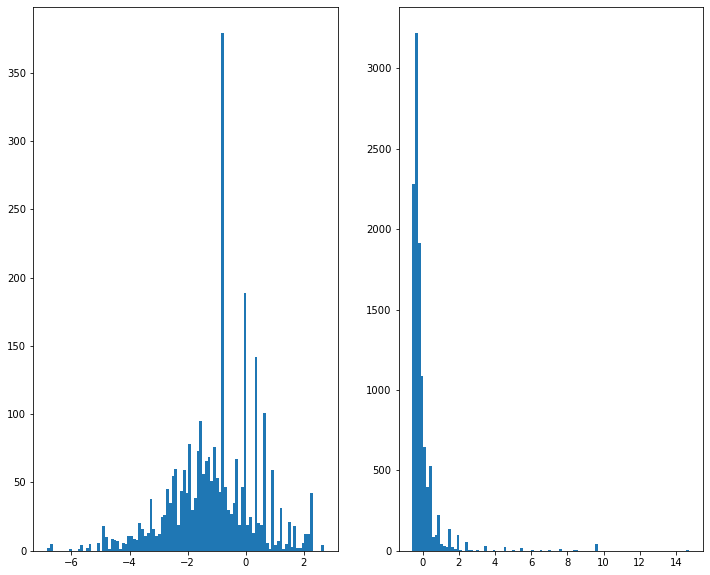

In [56]:
# print dataframe.
fig = plt.figure()
ax = fig.add_subplot(121)
ax.hist(np.log(train["TransactionAmt"]), bins=100);
ax = fig.add_subplot(122)
ax.hist(train["TransactionAmt"], bins=100);

In [269]:
check_categories()

P_emaildomain: 7
['gmail' 'anonymous' 'hotmail' 'other' 'outlook' 'yahoo' 'aol'] ....

gmail        4125
hotmail      3883
anonymous    1391
other         592
yahoo         580
outlook       372
aol           131
Name: P_emaildomain, dtype: int64


R_emaildomain: 7
['gmail' 'anonymous' 'hotmail' 'other' 'outlook' 'yahoo' 'aol'] ....

gmail        4156
hotmail      3879
anonymous    1387
other         596
yahoo         567
outlook       372
aol           117
Name: R_emaildomain, dtype: int64


id_31: 8
['chrome' 'android' 'ie' 'samsung' 'firefox' 'safari' 'other' 'opera'] ....

chrome     4801
android    3834
ie          901
firefox     615
samsung     391
safari      368
other       156
opera         8
Name: id_31, dtype: int64


DeviceInfo: 7
['windows' 'build' 'trident' 'ios' 'other' 'rv' 'moto'] ....

windows    4854
build      4516
other       644
trident     504
rv          309
ios         206
moto         41
Name: DeviceInfo, dtype: int64




In [270]:
# save train
train.to_pickle("train3.pkl")
# train = pd.read_pickle("train3.pkl")
print(train.shape)


(11074, 56)


## replace the last few NaN for the models

In [271]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(train[not_num_cols])
train[not_num_cols] = imp.transform(train[not_num_cols])

In [272]:
missing_vals(train)

                 vals  missing
col                           
isFraud             2      0.0
TransactionDT   11070      0.0
TransactionAmt   2895      0.0
ProductCD           3      0.0
card1            1031      0.0
card2             165      0.0
card3              54      0.0
card4               4      0.0
card5              46      0.0
card6               3      0.0
P_emaildomain       7      0.0
R_emaildomain       7      0.0
C1                108      0.0
C2                165      0.0
C3                  1      0.0
C4                 70      0.0
C5                  1      0.0
C6                 69      0.0
C7                 59      0.0
C8                 79      0.0
C9                  1      0.0
C10                84      0.0
C11                98      0.0
C12                91      0.0
C13               105      0.0
C14                48      0.0
D1                600      0.0
D2                825      0.0
D3                758      0.0
D4                711      0.0
D5      

In [273]:
print(train.shape)
enc = OneHotEncoder(handle_unknown='ignore')
array_hot_encoded = enc.fit_transform(train[not_num_cols])
enc.get_feature_names(not_num_cols)


(11074, 56)


array(['ProductCD_C', 'ProductCD_H', 'ProductCD_R',
       'card4_american express', 'card4_discover', 'card4_mastercard',
       'card4_visa', 'card6_charge card', 'card6_credit', 'card6_debit',
       'P_emaildomain_anonymous', 'P_emaildomain_aol',
       'P_emaildomain_gmail', 'P_emaildomain_hotmail',
       'P_emaildomain_other', 'P_emaildomain_outlook',
       'P_emaildomain_yahoo', 'R_emaildomain_anonymous',
       'R_emaildomain_aol', 'R_emaildomain_gmail',
       'R_emaildomain_hotmail', 'R_emaildomain_other',
       'R_emaildomain_outlook', 'R_emaildomain_yahoo', 'M4_M0', 'M4_M1',
       'M4_M2', 'id_12_Found', 'id_12_NotFound', 'id_15_Found',
       'id_15_New', 'id_15_Unknown', 'id_16_Found', 'id_16_NotFound',
       'id_28_Found', 'id_28_New', 'id_29_Found', 'id_29_NotFound',
       'id_31_android', 'id_31_chrome', 'id_31_firefox', 'id_31_ie',
       'id_31_opera', 'id_31_other', 'id_31_safari', 'id_31_samsung',
       'id_35_F', 'id_35_T', 'id_36_F', 'id_36_T', 'id_37_F', 

In [274]:
cols = pd.DataFrame(enc.transform(train[not_num_cols]).toarray(), columns=enc.get_feature_names(not_num_cols))
cols

,ProductCD_C,ProductCD_H,ProductCD_R,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,...,id_38_T,DeviceType_desktop,DeviceType_mobile,DeviceInfo_build,DeviceInfo_ios,DeviceInfo_moto,DeviceInfo_other,DeviceInfo_rv,DeviceInfo_trident,DeviceInfo_windows
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11069,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11070,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11071,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11072,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [275]:
train = train.drop(columns=not_num_cols).reset_index()
train = pd.concat([train, cols], axis=1)
train.shape

(11074, 102)

In [276]:
list(train.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D15',
 'id_01',
 'id_02',
 'id_05',
 'id_06',
 'id_11',
 'id_13',
 'id_17',
 'id_19',
 'id_20',
 'is_email_same',
 'ProductCD_C',
 'ProductCD_H',
 'ProductCD_R',
 'card4_american express',
 'card4_discover',
 'card4_mastercard',
 'card4_visa',
 'card6_charge card',
 'card6_credit',
 'card6_debit',
 'P_emaildomain_anonymous',
 'P_emaildomain_aol',
 'P_emaildomain_gmail',
 'P_emaildomain_hotmail',
 'P_emaildomain_other',
 'P_emaildomain_outlook',
 'P_emaildomain_yahoo',
 'R_emaildomain_anonymous',
 'R_emaildomain_aol',
 'R_emaildomain_gmail',
 'R_emaildomain_hotmail',
 'R_emaildomain_other',
 'R_emaildomain_outlook',
 'R_emaildomain_yahoo',
 'M4_M0',
 'M4_M1',
 'M4_M2',
 'id_12_Found',
 'id_12_NotFound',
 'id_15_Found',
 'id_15_New',
 'i

In [277]:
train.set_index("TransactionID", inplace=True)

In [278]:
y = train['isFraud']   #target classes
X = train.drop('isFraud', axis=1)
y

TransactionID
2987010    0
2987130    0
2987252    0
2987258    0
2987328    0
          ..
3577365    0
3577469    0
3577486    0
3577499    0
3577521    0
Name: isFraud, Length: 11074, dtype: int64

In [279]:
kNN = KNeighborsClassifier(n_neighbors=3)  
kNN_scores = cross_val_score(kNN, X, y, cv=5)
print("5x CV Accuracy kNNs: {0:.2f}".format(kNN_scores.mean())) 
kNN_scores


5x CV Accuracy kNNs: 0.94


array([0.94221219, 0.93679458, 0.93995485, 0.93769752, 0.93179765])